# **Goal is to use different models and tune them using GridSearchCV and/or RandomSearch**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# navigate to root directory of current file in order to access other files relatively
%cd /content/drive/MyDrive/Colab\ Notebooks/depressive-sentiment-analyzer/server-side/modelling

/content/drive/MyDrive/Colab Notebooks/depressive-sentiment-analyzer/server-side/modelling


In [3]:
# !pip install -U keras-tuner
!pip install seaborn
!pip install numpy
# !pip install pillow
!pip install scikit-learn
!pip install lazypredict
# !pip install split-folders
!pip install nltk
# !pip install csv
# !pip install tqdm
# !pip install networkx

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from utilities.loaders import (
    load_corpus,
    get_chars,
    load_lookup_array,
    save_lookup_array,
    load_meta_data,
    save_meta_data,
    get_top_models,
    load_model,
    save_model,
    create_metrics_df,
    create_classified_df)

from utilities.preprocessors import (
    remove_contractions,
    rem_non_alpha_num,
    rem_numeric,
    capitalize,
    filter_valid,
    partition_corpus,
    rem_stop_words,
    stem_corpus_words,
    lemmatize_corpus_words,
    strip_final_corpus,
    string_list_to_list,
    join_word_list,
    clean_tweets,
    lower_words,
    flatten_series_of_lists,
    decode_one_hot,
    re_encode_sparse_labels,
    translate_labels,
    encode_features,
    vectorize_sent)


from utilities.visualizers import (
    view_words,
    data_split_metric_values,
    view_value_frequency,
    multi_class_heatmap,
    view_metric_values,
    view_classified_labels,
    view_label_freq,
    describe_col,
    ModelResults,
    plot_all_features,
    view_all_splits_results)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data

In [5]:
ddr = pd.read_csv('./data/depression_dataset_reddit_cleaned.csv', )
ddr

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


# Preprocessing

In [6]:
ddr.rename(columns={'is_depression': 'label'}, inplace=True)
ddr

,clean_text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


In [7]:
ddr['clean_text'] = ddr['clean_text'].apply(lower_words)
ddr

Streaming output truncated to the last 5000 lines.
i ve been on med for a few year now which have worked for the most part up until last year i contracted an illness which gave me stomach problem and the issue ha kind of persisted ever since my health ha never been great eating disorder and weight issue mainly a well a really unsightly skin but this stomach issue ha taken what life i had away and now a much a i m not screaming and cry about wanting to die it almost feel like a logical step at this point i want to live i want to have a life and live it freely to the fullest but i m trapped now in this body and have to cancel most plan i do make if i couldn t work from home i d probably be jobless and the work that is site based i let people down on a lot which i hate i feel like a failed experiment of a human that should just be put in the bin i feel guilty because of the somewhat privilege i do have but that s still not been enough i ve failed myself and now my body is failing me there

,clean_text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


In [8]:
ddr['clean_text'] = ddr['clean_text'].apply(remove_contractions)
ddr

Streaming output truncated to the last 5000 lines.
i ve been on med for a few year now which have worked for the most part up until last year i contracted an illness which gave me stomach problem and the issue ha kind of persisted ever since my health ha never been great eating disorder and weight issue mainly a well a really unsightly skin but this stomach issue ha taken what life i had away and now a much a i m not screaming and cry about wanting to die it almost feel like a logical step at this point i want to live i want to have a life and live it freely to the fullest but i m trapped now in this body and have to cancel most plan i do make if i couldn t work from home i d probably be jobless and the work that is site based i let people down on a lot which i hate i feel like a failed experiment of a human that should just be put in the bin i feel guilty because of the somewhat privilege i do have but that s still not been enough i ve failed myself and now my body is failing me there

,clean_text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


In [9]:
ddr['clean_text'] = ddr['clean_text'].apply(rem_non_alpha_num)
ddr

Streaming output truncated to the last 5000 lines.
i ve been on med for a few year now which have worked for the most part up until last year i contracted an illness which gave me stomach problem and the issue ha kind of persisted ever since my health ha never been great eating disorder and weight issue mainly a well a really unsightly skin but this stomach issue ha taken what life i had away and now a much a i m not screaming and cry about wanting to die it almost feel like a logical step at this point i want to live i want to have a life and live it freely to the fullest but i m trapped now in this body and have to cancel most plan i do make if i couldn t work from home i d probably be jobless and the work that is site based i let people down on a lot which i hate i feel like a failed experiment of a human that should just be put in the bin i feel guilty because of the somewhat privilege i do have but that s still not been enough i ve failed myself and now my body is failing me there

,clean_text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


In [10]:
ddr['clean_text'] = ddr['clean_text'].apply(rem_numeric)
ddr

Streaming output truncated to the last 5000 lines.
i ve been on med for a few year now which have worked for the most part up until last year i contracted an illness which gave me stomach problem and the issue ha kind of persisted ever since my health ha never been great eating disorder and weight issue mainly a well a really unsightly skin but this stomach issue ha taken what life i had away and now a much a i m not screaming and cry about wanting to die it almost feel like a logical step at this point i want to live i want to have a life and live it freely to the fullest but i m trapped now in this body and have to cancel most plan i do make if i couldn t work from home i d probably be jobless and the work that is site based i let people down on a lot which i hate i feel like a failed experiment of a human that should just be put in the bin i feel guilty because of the somewhat privilege i do have but that s still not been enough i ve failed myself and now my body is failing me there

,clean_text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


In [11]:
ddr['clean_text'] = ddr['clean_text'].apply(rem_stop_words)
ddr

Streaming output truncated to the last 5000 lines.
med year worked part last year contracted illness gave stomach problem issue ha kind persisted ever since health ha never great eating disorder weight issue mainly well really unsightly skin stomach issue ha taken life away much screaming cry wanting die almost feel like logical step point want live want life live freely fullest trapped body cancel plan make work home probably jobless work site based let people lot hate feel like failed experiment human put bin feel guilty somewhat privilege still enough failed body failing also history cancer tumour family make scared lose ability use limb like mom anyone life take care like doe point sitting around waiting time come every week fight get back track always step forward back scared die feel like choice putting inevitable even know best way even much coward always one little bit hope holding back light hope getting dimmer day
depression bad function properly shower every day brush teeth 

,clean_text,label
0,understand people reply immediately op invitat...,1
1,welcome r depression check post place take mom...,1
2,anyone else instead sleeping depressed stay ni...,1
3,kind stuffed around lot life delaying inevitab...,1
4,sleep greatest comforting escape whenever wake...,1
...,...,...
7726,snow,0
7727,moulin rouge mad cry,0
7728,trying shout find people list,0
7729,ughh find red sox hat got ta wear creepy nick ...,0


In [12]:
ddr['clean_text'] = ddr['clean_text'].apply(stem_corpus_words)
ddr

Streaming output truncated to the last 5000 lines.
med year work part last year contract ill gave stomach problem issu ha kind persist ever sinc health ha never great eat disord weight issu main well realli unsight skin stomach issu ha taken life away much scream cri want die almost feel like logic step point want live want life live freeli fullest trap bodi cancel plan make work home probabl jobless work site base let peopl lot hate feel like fail experi human put bin feel guilti somewhat privileg still enough fail bodi fail also histori cancer tumour famili make scare lose abil use limb like mom anyon life take care like doe point sit around wait time come everi week fight get back track alway step forward back scare die feel like choic put inevit even know best way even much coward alway one littl bit hope hold back light hope get dimmer day
depress bad function proper shower everi day brush teeth everi week fear caus problem futur ate like donut chip fat btw lol fuck bring get bed 

,clean_text,label
0,understand peopl repli immedi op invit talk pr...,1
1,welcom r depress check post place take moment ...,1
2,anyon els instead sleep depress stay night avo...,1
3,kind stuf around lot life delay inevit work jo...,1
4,sleep greatest comfort escap whenev wake day l...,1
...,...,...
7726,snow,0
7727,moulin roug mad cri,0
7728,tri shout find peopl list,0
7729,ughh find red sox hat got ta wear creepi nick ...,0


In [13]:
ddr['clean_text'] = ddr['clean_text'].apply(lemmatize_corpus_words)
ddr

Streaming output truncated to the last 5000 lines.
med year work part last year contract ill gave stomach problem issu ha kind persist ever sinc health ha never great eat disord weight issu main well realli unsight skin stomach issu ha taken life away much scream cri want die almost feel like logic step point want live want life live freeli fullest trap bodi cancel plan make work home probabl jobless work site base let peopl lot hate feel like fail experi human put bin feel guilti somewhat privileg still enough fail bodi fail also histori cancer tumour famili make scare lose abil use limb like mom anyon life take care like doe point sit around wait time come everi week fight get back track alway step forward back scare die feel like choic put inevit even know best way even much coward alway one littl bit hope hold back light hope get dimmer day
depress bad function proper shower everi day brush teeth everi week fear caus problem futur ate like donut chip fat btw lol fuck bring get bed 

,clean_text,label
0,understand peopl repli immedi op invit talk pr...,1
1,welcom r depress check post place take moment ...,1
2,anyon el instead sleep depress stay night avoi...,1
3,kind stuf around lot life delay inevit work jo...,1
4,sleep greatest comfort escap whenev wake day l...,1
...,...,...
7726,snow,0
7727,moulin roug mad cri,0
7728,tri shout find peopl list,0
7729,ughh find red sox hat got ta wear creepi nick ...,0


In [14]:
ddr['clean_text'] = ddr['clean_text'].apply(strip_final_corpus)
ddr

,clean_text,label
0,understand peopl repli immedi op invit talk pr...,1
1,welcom r depress check post place take moment ...,1
2,anyon el instead sleep depress stay night avoi...,1
3,kind stuf around lot life delay inevit work jo...,1
4,sleep greatest comfort escap whenev wake day l...,1
...,...,...
7726,snow,0
7727,moulin roug mad cri,0
7728,tri shout find peopl list,0
7729,ughh find red sox hat got ta wear creepi nick ...,0


In [15]:
ddr['label'] = re_encode_sparse_labels(ddr['label'], new_labels=['NDP', 'DPR'])
ddr

,clean_text,label
0,understand peopl repli immedi op invit talk pr...,DPR
1,welcom r depress check post place take moment ...,DPR
2,anyon el instead sleep depress stay night avoi...,DPR
3,kind stuf around lot life delay inevit work jo...,DPR
4,sleep greatest comfort escap whenev wake day l...,DPR
...,...,...
7726,snow,NDP
7727,moulin roug mad cri,NDP
7728,tri shout find peopl list,NDP
7729,ughh find red sox hat got ta wear creepi nick ...,NDP


In [16]:
ddr['label'], ddr_le = encode_features(ddr['label'])
ddr

,clean_text,label
0,understand peopl repli immedi op invit talk pr...,0
1,welcom r depress check post place take moment ...,0
2,anyon el instead sleep depress stay night avoi...,0
3,kind stuf around lot life delay inevit work jo...,0
4,sleep greatest comfort escap whenev wake day l...,0
...,...,...
7726,snow,1
7727,moulin roug mad cri,1
7728,tri shout find peopl list,1
7729,ughh find red sox hat got ta wear creepi nick ...,1


In [17]:
save_model(ddr_le, './saved/misc/ddr_le.pkl')

In [18]:
ddr_le.inverse_transform(ddr['label'])

array(['DPR', 'DPR', 'DPR', ..., 'NDP', 'NDP', 'NDP'], dtype=object)

# Data Analysis and Visualization

/content/drive/MyDrive/Colab Notebooks/depressive-sentiment-analyzer/server-side/modelling/utilities/visualizers.py:281: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  axis = sb.barplot(x=label_freq.values, y=labels, palette="flare") \


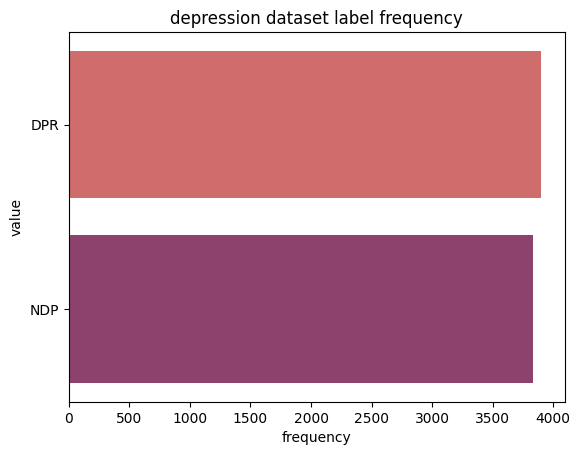

In [19]:
view_label_freq(ddr['label'].value_counts(), img_title='depression dataset label frequency', save_img=True, labels=['DPR', 'NDP'])

In [20]:
parted_sents = ddr['clean_text'].apply(partition_corpus)
parted_sents

Streaming output truncated to the last 5000 lines.
med year work part last year contract ill gave stomach problem issu ha kind persist ever sinc health ha never great eat disord weight issu main well realli unsight skin stomach issu ha taken life away much scream cri want die almost feel like logic step point want live want life live freeli fullest trap bodi cancel plan make work home probabl jobless work site base let peopl lot hate feel like fail experi human put bin feel guilti somewhat privileg still enough fail bodi fail also histori cancer tumour famili make scare lose abil use limb like mom anyon life take care like doe point sit around wait time come everi week fight get back track alway step forward back scare die feel like choic put inevit even know best way even much coward alway one littl bit hope hold back light hope get dimmer day
depress bad function proper shower everi day brush teeth everi week fear caus problem futur ate like donut chip fat btw lol fuck bring get bed 

0       [understand, peopl, repli, immedi, op, invit, ...
1       [welcom, r, depress, check, post, place, take,...
2       [anyon, el, instead, sleep, depress, stay, nig...
3       [kind, stuf, around, lot, life, delay, inevit,...
4       [sleep, greatest, comfort, escap, whenev, wake...
                              ...                        
7726                                               [snow]
7727                             [moulin, roug, mad, cri]
7728                      [tri, shout, find, peopl, list]
7729    [ughh, find, red, sox, hat, got, ta, wear, cre...
7730    [slept, wonder, final, tri, swatch, new, proje...
Name: clean_text, Length: 7731, dtype: object

# See all the top words associated with the DPR label

In [21]:
all_dep_words = flatten_series_of_lists(parted_sents[ddr['label'] == 0])
all_dep_words

0         understand
1              peopl
2              repli
3             immedi
4                 op
             ...    
234929          http
234930            co
234931             b
234932          lryf
234933             n
Length: 234934, dtype: object

In [22]:
all_dep_words.value_counts()

feel          3993
wa            3526
like          3487
get           2616
want          2578
              ... 
ciggarrett       1
shopkick         1
carotid          1
asprin           1
lryf             1
Length: 10827, dtype: int64

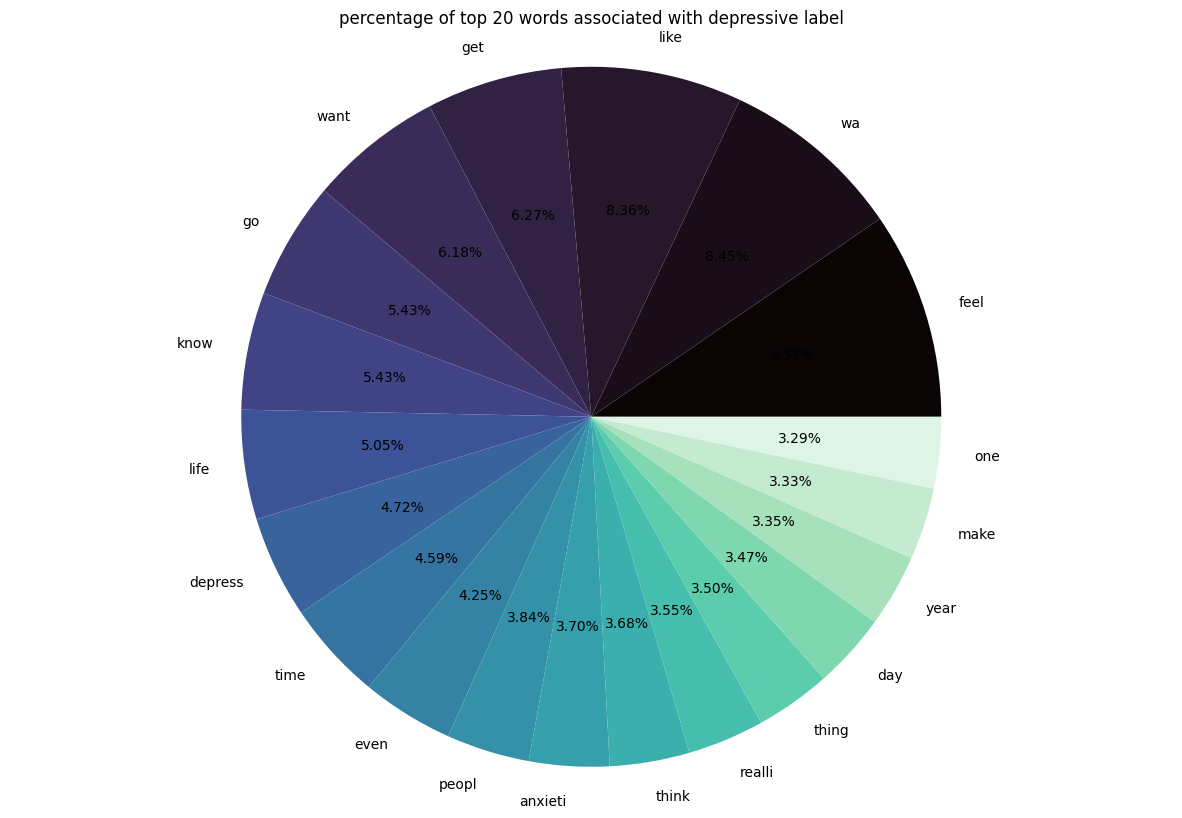

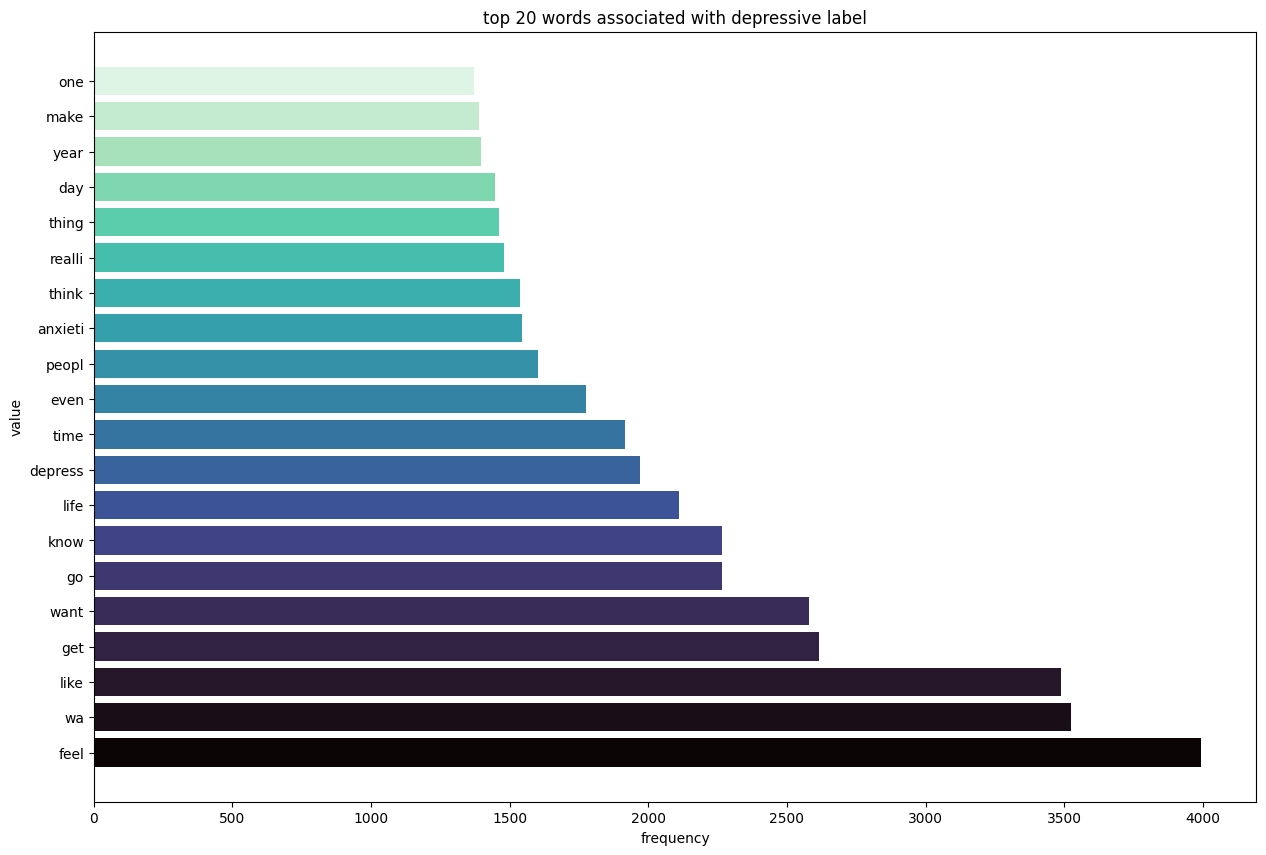

In [23]:
view_value_frequency(all_dep_words.value_counts(), colormap='mako', title="percentage of top 20 words associated with depressive label", save_img=True, kind='pie', limit=20, asc=False)
view_value_frequency(all_dep_words.value_counts(), colormap='mako', title="top 20 words associated with depressive label", save_img=True, kind='barh', limit=20, asc=False)

# See the top words associated with the NDP label

In [24]:
all_ndep_words = flatten_series_of_lists(parted_sents[ddr['label'] == 1])
all_ndep_words

0        switchfoot
1              http
2           twitpic
3               com
4                zl
            ...    
30521         stash
30522          like
30523         color
30524          must
30525          wait
Length: 30526, dtype: object

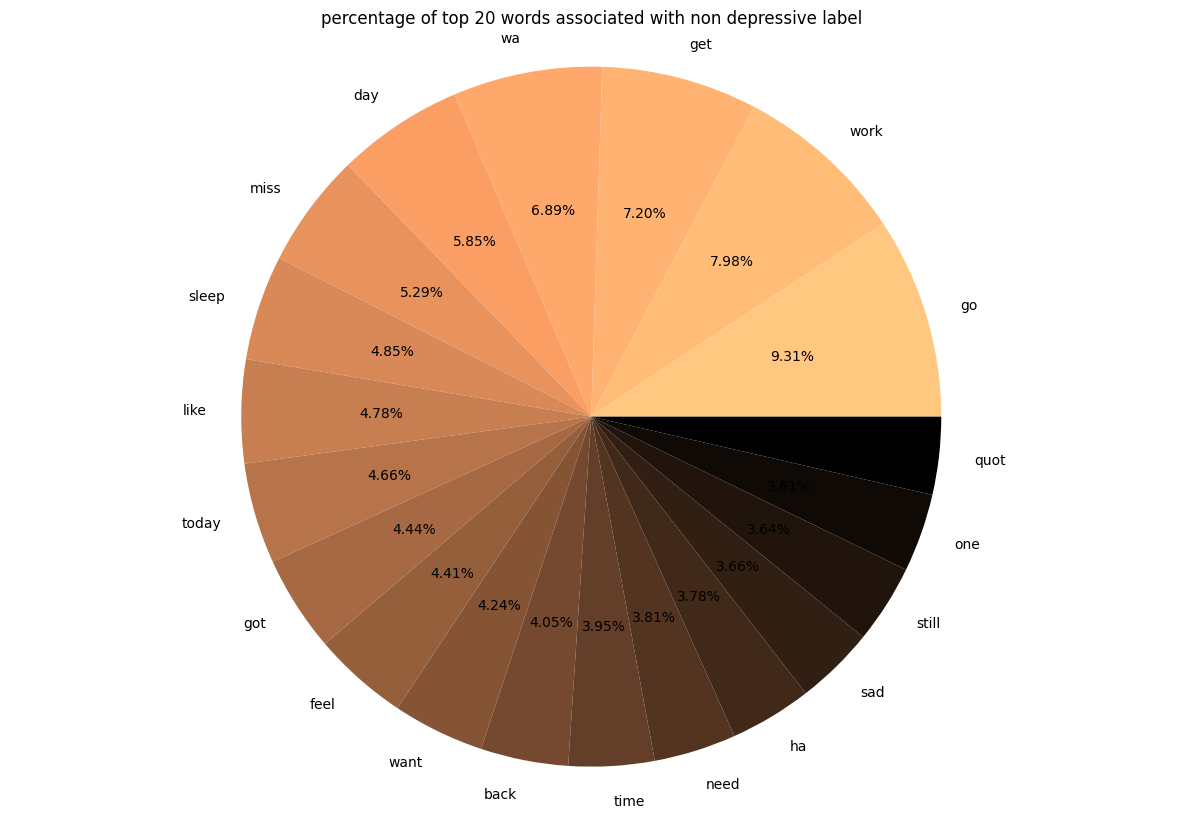

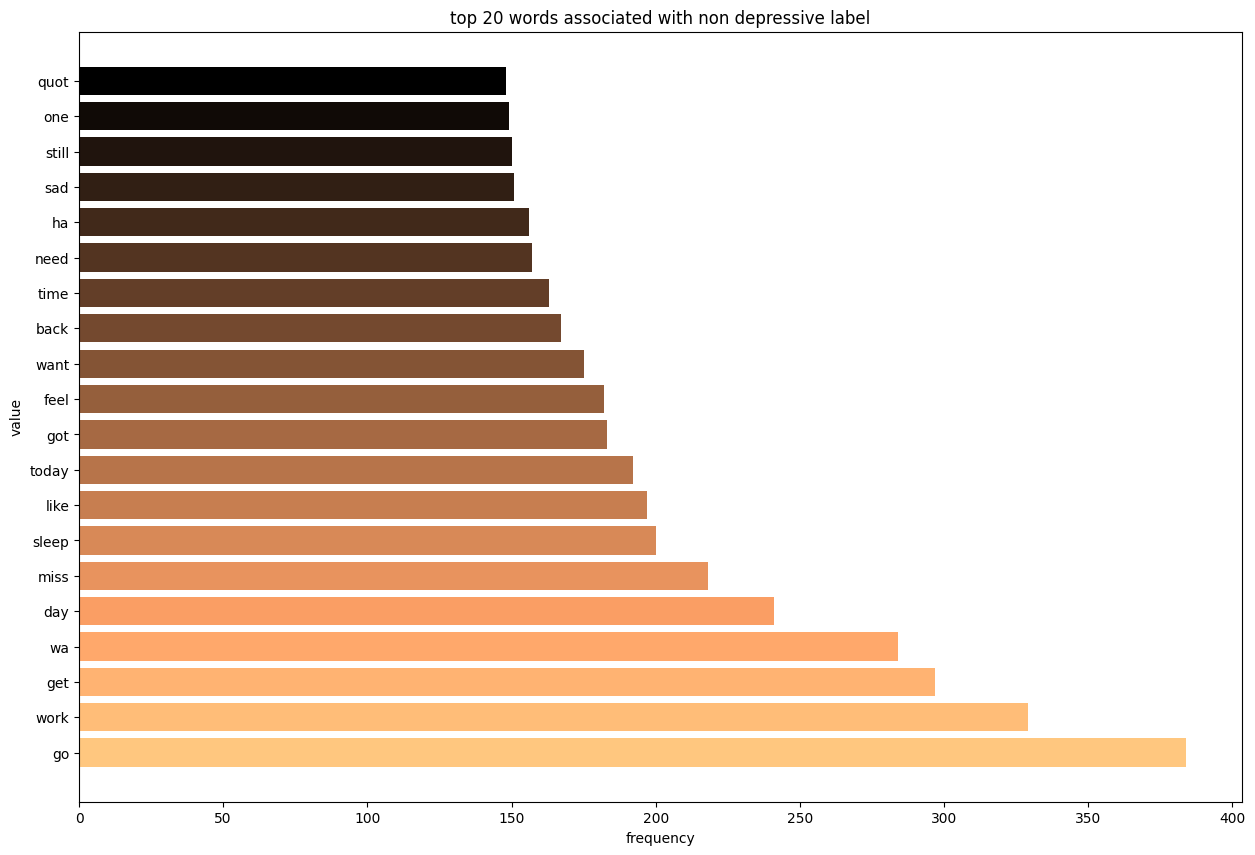

In [25]:
view_value_frequency(all_ndep_words.value_counts(), colormap='copper_r', title="percentage of top 20 words associated with non depressive label", save_img=True, kind='pie', limit=20, asc=False)
view_value_frequency(all_ndep_words.value_counts(), colormap='copper_r', title="top 20 words associated with non depressive label", save_img=True, kind='barh', limit=20, asc=False)

In [26]:
X_trains, X_, Y_trains, Y_ = train_test_split(ddr['clean_text'], ddr['label'], test_size=0.3, random_state=0)
X_cross, X_tests, Y_cross, Y_tests = train_test_split(X_, Y_, test_size=0.5, random_state=0)

In [27]:
X_trains

6778                        tombot never mind work anyway
189     hey everyon long time reader sub wan na say fi...
4521                                       got text sarah
7083       andr riue neighbour ha world come internet lol
6885                      play pkr onlin poker ha headach
                              ...                        
4931    morn starv die cuppa co doc fast blood test littl
3264                                              depress
1653    tw mention anxieti ocd allerg reaction back st...
2607    noth life good school shit quit weed witch wa ...
2732    depress bad function proper shower everi day b...
Name: clean_text, Length: 5411, dtype: object

In [28]:
X_trains_vec, X_cross_vec, X_tests_vec, vectorizer = vectorize_sent(X_trains, X_cross, X_tests)

In [29]:
save_model(vectorizer, './saved/misc/ddr_tfidf_vec.pkl')

# Now we have the vectorized form of our dataset which we can use as features for our classifier

In [30]:
X_trains_vec.shape

(5411, 12061)

In [31]:
np.unique(X_trains_vec)

array([0.        , 0.00795248, 0.00861848, ..., 0.95954072, 0.96652224,
       1.        ])

In [32]:
X_cross_vec.shape

(1160, 12061)

In [33]:
X_tests_vec.shape

(1160, 12061)

# Ensemble Modelling using lazy predict

In [35]:
from lazypredict.Supervised import LazyClassifier

In [36]:
ddr_lazy_clf = LazyClassifier(verbose=0,
    ignore_warnings=True,
    custom_metric=None,)
ddr_lazy_clf_train, _ = ddr_lazy_clf.fit(X_trains_vec, X_trains_vec, Y_trains, Y_trains)
ddr_lazy_clf_cross, _ = ddr_lazy_clf.fit(X_trains_vec, X_cross_vec, Y_trains, Y_cross)

 97%|█████████▋| 28/29 [44:08<02:09, 129.73s/it]

[LightGBM] [Info] Number of positive: 2746, number of negative: 2665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38652
[LightGBM] [Info] Number of data points in the train set: 5411, number of used features: 1128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507485 -> initscore=0.029941
[LightGBM] [Info] Start training from score 0.029941


100%|██████████| 29/29 [44:19<00:00, 91.71s/it] 


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 97%|█████████▋| 28/29 [34:14<01:19, 79.20s/it] 

[LightGBM] [Info] Number of positive: 2746, number of negative: 2665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38652
[LightGBM] [Info] Number of data points in the train set: 5411, number of used features: 1128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507485 -> initscore=0.029941
[LightGBM] [Info] Start training from score 0.029941


100%|██████████| 29/29 [34:22<00:00, 71.13s/it]


In [40]:
ddr_lazy_clf_train[:10]

,Train Accuracy,Train Balanced Accuracy,Train ROC AUC,Train F1 Score,Train Time Taken
Model,,,,,
DecisionTreeClassifier,1.00,1.00,1.00,1.00,19.12
ExtraTreeClassifier,1.00,1.00,1.00,1.00,4.82
ExtraTreesClassifier,1.00,1.00,1.00,1.00,72.68
LabelPropagation,1.00,1.00,1.00,1.00,24.36
LabelSpreading,1.00,1.00,1.00,1.00,24.59
LinearSVC,1.00,1.00,1.00,1.00,119.51
CalibratedClassifierCV,1.00,1.00,1.00,1.00,484.52
RandomForestClassifier,1.00,1.00,1.00,1.00,26.88
QuadraticDiscriminantAnalysis,1.00,1.00,1.00,1.00,94.39


In [41]:
ddr_lazy_clf_cross[:10]

,Cross Accuracy,Cross Balanced Accuracy,Cross ROC AUC,Cross F1 Score,Cross Time Taken
Model,,,,,
LGBMClassifier,0.96,0.96,0.96,0.96,8.24
XGBClassifier,0.95,0.95,0.95,0.95,36.26
AdaBoostClassifier,0.95,0.95,0.95,0.95,75.06
RandomForestClassifier,0.93,0.93,0.93,0.93,25.17
ExtraTreesClassifier,0.93,0.93,0.93,0.93,70.39
BaggingClassifier,0.89,0.89,0.89,0.89,99.47
LogisticRegression,0.89,0.89,0.89,0.89,12.90
NearestCentroid,0.88,0.88,0.88,0.88,2.84
DecisionTreeClassifier,0.88,0.88,0.88,0.88,18.29


In [39]:
# merge both first 10 rows of training and testing model dataframes
top_ddr_lazy_clf_models = get_top_models(ddr_lazy_clf_train, ddr_lazy_clf_cross, model_type='classifier')
top_ddr_lazy_clf_models

,Model,Train Accuracy,Train Balanced Accuracy,Train ROC AUC,Train F1 Score,Train Time Taken,Cross Accuracy,Cross Balanced Accuracy,Cross ROC AUC,Cross F1 Score,Cross Time Taken
2,RandomForestClassifier,1.00,1.00,1.00,1.00,26.88,0.93,0.93,0.93,0.93,25.17
1,ExtraTreesClassifier,1.00,1.00,1.00,1.00,72.68,0.93,0.93,0.93,0.93,70.39
0,DecisionTreeClassifier,1.00,1.00,1.00,1.00,19.12,0.88,0.88,0.88,0.88,18.29


# Loading top models like ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, XGBRegressor, LGBMRegressor, HistGradientBoostingRegressor, BaggingRegressor, DecisionTreeRegressor for regression and LGBMClassifier, XGBClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier for classification

In [34]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier

In [35]:
from sklearn.pipeline import Pipeline

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [51]:
name = recall_score.__name__
name

'recall_score'

# Some important hyper parameters that we might use to tune for instance an XGBClassifier
n_estimators (Optional[int]) – Number of boosting rounds.

max_depth (Optional[int]) – Maximum tree depth for base learners.

max_leaves – Maximum number of leaves; 0 indicates no limit.

learning_rate (Optional[float]) – Boosting learning rate (xgb’s “eta”)

booster (Optional[str]) – Specify which booster to use: gbtree, gblinear or dart.

tree_method (Optional[str]) – Specify which tree method to use. Default to auto. If this parameter is set to default, XGBoost will choose the most conservative option available. It’s recommended to study this option from the parameters document tree method

reg_alpha (Optional[float]) – L1 regularization term on weights (xgb’s alpha).

reg_lambda (Optional[float]) - L2 regularization term on weights (xgb’s lambda).

In [36]:
ddr_lgbm_clf = LGBMClassifier()
ddr_xgb_clf = XGBClassifier()
ddr_ada_clf = AdaBoostClassifier()

In [37]:
ddr_lgbm_clf.fit(X_trains_vec, Y_trains)
ddr_xgb_clf.fit(X_trains_vec, Y_trains)
ddr_ada_clf.fit(X_trains_vec, Y_trains)

[LightGBM] [Info] Number of positive: 2746, number of negative: 2665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37528
[LightGBM] [Info] Number of data points in the train set: 5411, number of used features: 1128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507485 -> initscore=0.029941
[LightGBM] [Info] Start training from score 0.029941


AdaBoostClassifier()

In [42]:
ddr_lgbm_clf.score(X_cross_vec, Y_cross)

0.9577586206896552

In [43]:
ddr_xgb_clf.score(X_cross_vec, Y_cross)

0.9543103448275863

In [44]:
ddr_ada_clf.score(X_cross_vec, Y_cross)

0.95

# Metric values of lightgradientboostedmachineclassifier

In [47]:
ddr_lgbm_Y_preds_train = ddr_lgbm_clf.predict(X_trains_vec)
ddr_lgbm_Y_preds_cross = ddr_lgbm_clf.predict(X_cross_vec)
ddr_lgbm_Y_preds_test = ddr_lgbm_clf.predict(X_tests_vec)

In [57]:
train_lgbm_metric_values = data_split_metric_values(Y_trains, ddr_lgbm_Y_preds_train)
cross_lgbm_metric_values = data_split_metric_values(Y_cross, ddr_lgbm_Y_preds_cross)
test_lgbm_metric_values = data_split_metric_values(Y_tests, ddr_lgbm_Y_preds_test)
train_lgbm_metric_values

{'accuracy': 0.9931620772500462,
 'precision': 0.9932342526595124,
 'recall': 0.9931620772500462,
 'f1': 0.9931611982665395,
 'roc-auc': 0.9930692298126971}

In [58]:
lgbm_metrics_df = create_metrics_df(list(train_lgbm_metric_values.values()),
                  list(cross_lgbm_metric_values.values()),
                  list(test_lgbm_metric_values.values()),
                  metrics=['accuracy', 'precision', 'recall', 'f1-score', 'roc-auc'])

In [59]:
lgbm_metrics_df

,data_split,accuracy,precision,recall,f1-score,roc-auc
0,training,0.993162,0.993234,0.993162,0.993161,0.993069
1,validation,0.957759,0.957927,0.957759,0.957757,0.957807
2,testing,0.951724,0.952167,0.951724,0.951716,0.951803


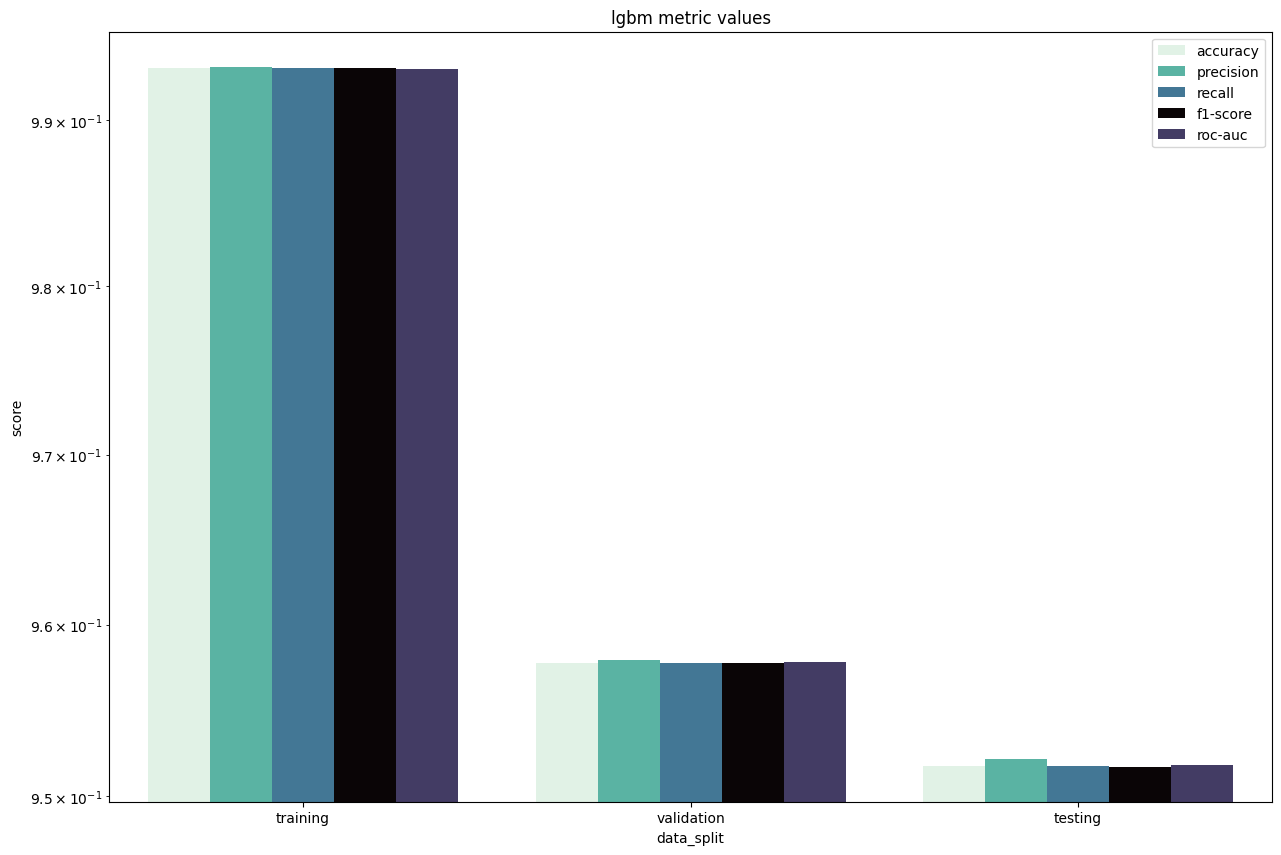

In [61]:
view_metric_values(lgbm_metrics_df, 'lgbm metric values', save_img=True)

# COnfusion matrix should have been included here

# Metric values of xgboostclassifier

In [62]:
ddr_xgb_Y_preds_train = ddr_xgb_clf.predict(X_trains_vec)
ddr_xgb_Y_preds_cross = ddr_xgb_clf.predict(X_cross_vec)
ddr_xgb_Y_preds_test = ddr_xgb_clf.predict(X_tests_vec)

In [63]:
train_xgb_metric_values = data_split_metric_values(Y_trains, ddr_xgb_Y_preds_train)
cross_xgb_metric_values = data_split_metric_values(Y_cross, ddr_xgb_Y_preds_cross)
test_xgb_metric_values = data_split_metric_values(Y_tests, ddr_xgb_Y_preds_test)

In [64]:
xgb_metrics_df = create_metrics_df(list(train_xgb_metric_values.values()),
                  list(cross_xgb_metric_values.values()),
                  list(test_xgb_metric_values.values()),
                  metrics=['accuracy', 'precision', 'recall', 'f1-score', 'roc-auc'])

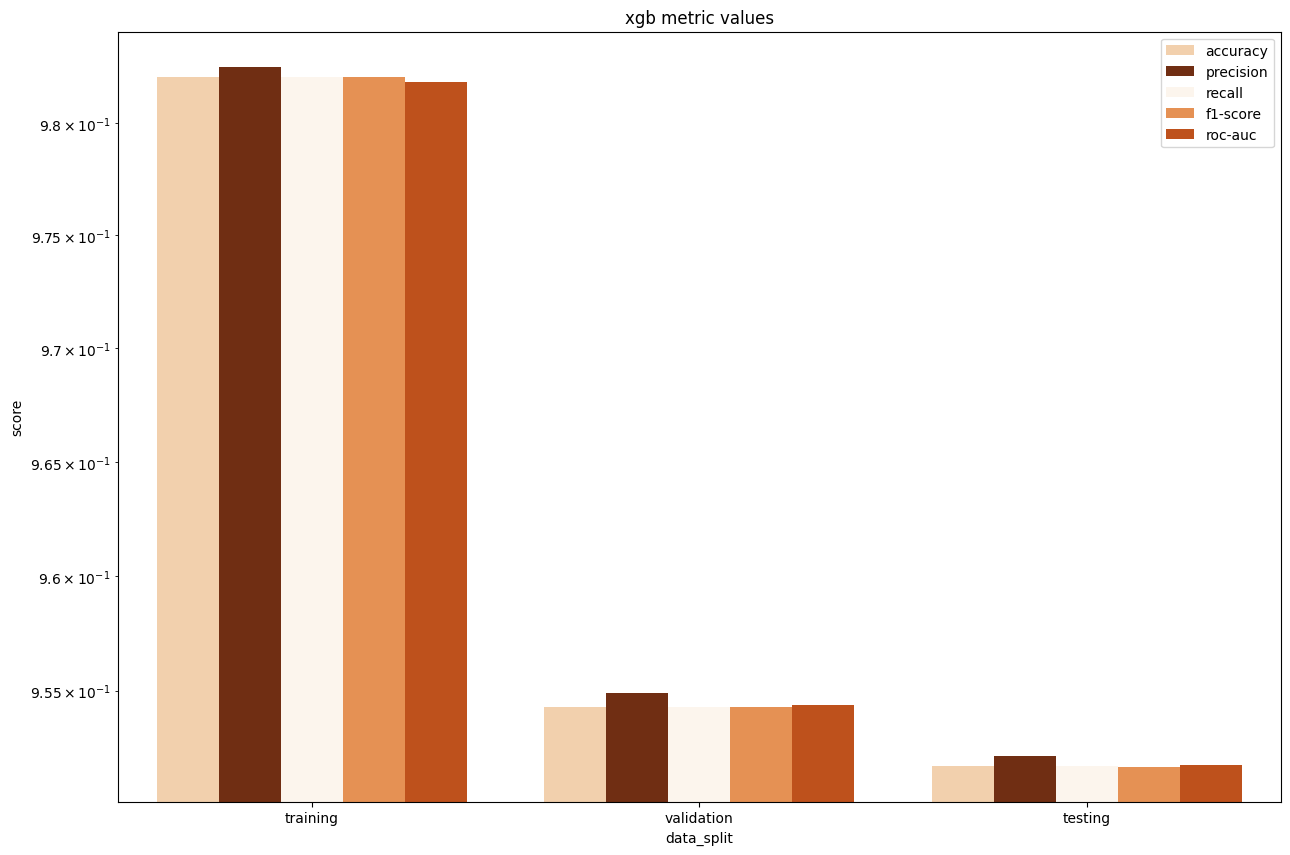

In [66]:
view_metric_values(xgb_metrics_df, 'xgb metric values', save_img=True, colormap='Oranges_r')

# Metric values of adaboostclassifier

In [67]:
ddr_ada_Y_preds_train = ddr_ada_clf.predict(X_trains_vec)
ddr_ada_Y_preds_cross = ddr_ada_clf.predict(X_cross_vec)
ddr_ada_Y_preds_test = ddr_ada_clf.predict(X_tests_vec)

In [68]:
train_ada_metric_values = data_split_metric_values(Y_trains, ddr_ada_Y_preds_train)
cross_ada_metric_values = data_split_metric_values(Y_cross, ddr_ada_Y_preds_cross)
test_ada_metric_values = data_split_metric_values(Y_tests, ddr_ada_Y_preds_test)

In [69]:
ada_metrics_df = create_metrics_df(list(train_ada_metric_values.values()),
                  list(cross_ada_metric_values.values()),
                  list(test_ada_metric_values.values()),
                  metrics=['accuracy', 'precision', 'recall', 'f1-score', 'roc-auc'])

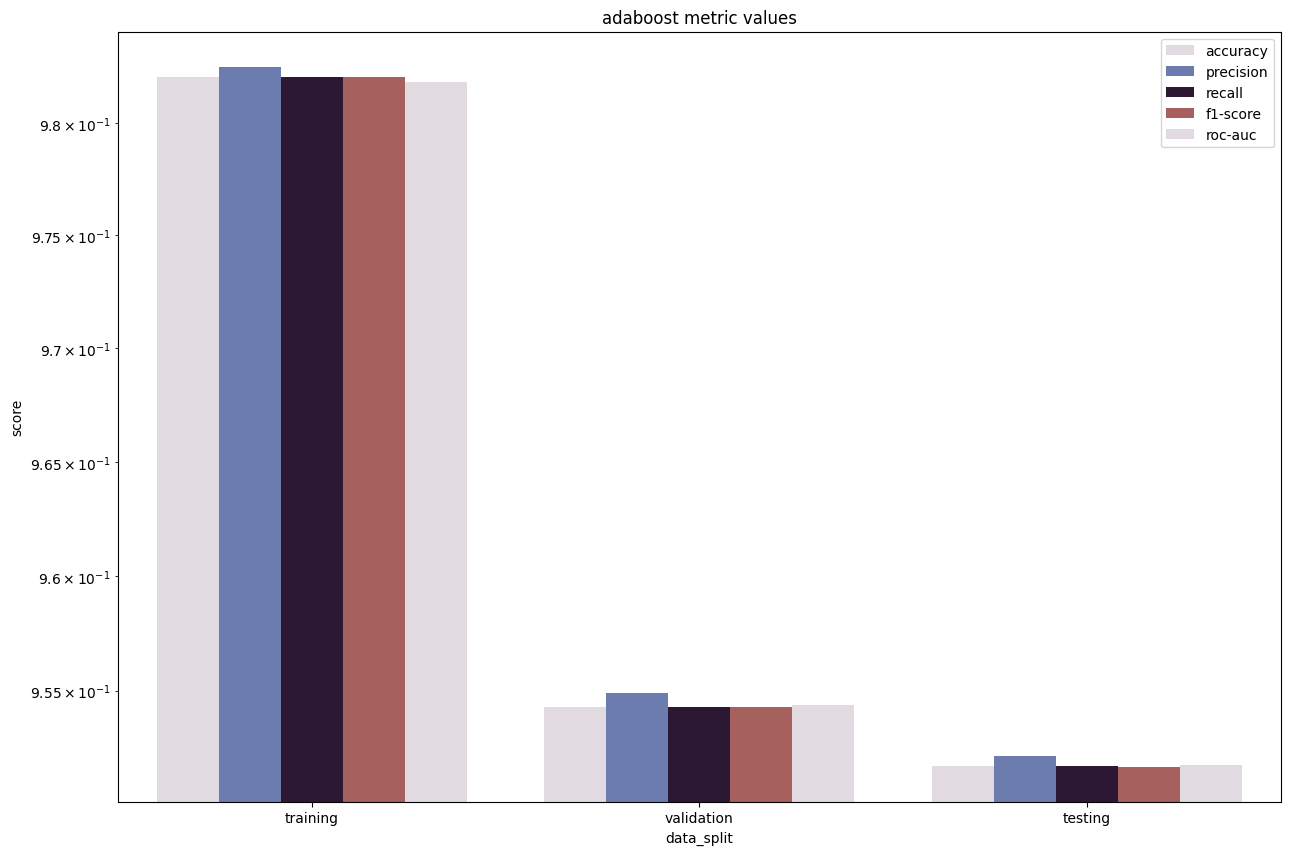

In [72]:
view_metric_values(xgb_metrics_df, 'adaboost metric values', save_img=True, colormap='twilight_r')

In [38]:
save_model(ddr_lgbm_clf, './saved/models/lgbm_clf.pkl')
save_model(ddr_xgb_clf, './saved/models/xgb_clf.pkl')
save_model(ddr_ada_clf, './saved/models/ada_clf.pkl')

In [39]:
hyper_params = {
    'n_estimators': [5, 10, 50, 100, 150, 200],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.0075, 0.001, 0.003, 0.0001],
    'reg_lambda': [1, 0.9, 0.8, 0.7, 0.6, 0.5],
}

In [40]:
ddr_lgbm_grid = HalvingGridSearchCV(ddr_lgbm_clf, hyper_params, factor=3, min_resources=10, cv=3, verbose=1)

In [41]:
# ddr_lgbm_grid.fit(X_trains_vec, Y_trains)